In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tqdm as tqdm
import sys

sys.path.append('..')
import interpolator
import pyvo

import sys, os
wdmodels_dir = os.environ['WDMODELS_DIR']
sys.path.append(wdmodels_dir)
import WD_models

plt.style.use('stefan.mplstyle')

In [2]:
# interpolator.interpolator.purge_cachetables()

In [3]:
"""compute the radial velocity from radius and effective temperature
"""
mass_sun, radius_sun, newton_G, speed_light = 1.9884e30, 6.957e8, 6.674e-11, 299792458
font_model = WD_models.load_model('f', 'f', 'f', 'H')
g_acc = (10**font_model['logg'])/100
rsun = np.sqrt(font_model['mass_array'] * mass_sun * newton_G / g_acc) / radius_sun
logg_function = WD_models.interp_xy_z_func(x = 10**font_model['logteff'], y = font_model['logg'],\
                                            z = rsun, interp_type = 'linear')

In [4]:
tap_service = pyvo.dal.TAPService("http://TAPVizieR.u-strasbg.fr/TAPVizieR/tap/")
QUERY = f"""select top 1000 *
        from \"J/MNRAS/508/3877/maincat\"
        where TeffH is not NULL and MassH is not NULL and meanAV is not NULL and RPlx > 3"""
ngfdata = tap_service.search(QUERY).to_table().to_pandas()

In [5]:
def fit_row(row : pd.Series, interp : interpolator.WarwickPhotometry):
    plx, zp, av = row.Plx, row.ZPcor, row.meanAV
    dist = 1000 / (plx + zp)
    mags = row[['GmagCorr', 'BPmag', 'RPmag']].values
    e_mags = row[['e_GmagCorr', 'e_BPmag', 'e_RPmag']].values
    fluxes, e_fluxes = interpolator.fit.mag_to_flux(mags, e_mags, interp.bands)
    res = interpolator.fit.coarse_fit(flux = fluxes, e_flux = e_fluxes, interp = interp, distance = dist, av = av,
                logg_function = logg_function, p0 = [10000, 8, 0.6], coarse_kws = {'method':'leastsq', 'nan_policy':'propagate'})
    return res

interp = interpolator.WarwickPhotometry(model='1d_da_nlte', bands=['Gaia_G', 'Gaia_BP', 'Gaia_RP'], speckws={'wavl_range' : (1000,14000), 'units' : 'flam'})
interpspec = interpolator.WarwickSpectrum(model='1d_da_nlte', wavl_range = (1000,14000), units = 'flam')
values = np.zeros((len(ngfdata), 6))
for i, row in tqdm.tqdm(ngfdata.iterrows(), total=len(ngfdata)):
    res = fit_row(row, interp)
    teff, radius, distance = res.params['teff'].value, res.params['logg'].value, res.params['distance'].value
    av = res.params['av'].value#, res.params['mass'].value
    values[i,0] = row.GaiaEDR3
    values[i,1] = teff
    values[i,2] = radius
    values[i,3] = distance
    values[i,4] = av
    values[i,5] = res.redchi
leastsq = pd.DataFrame(values, columns=['GaiaEDR3', 'teff', 'logg', 'distance', 'av', 'redchi'])

100%|██████████| 1000/1000 [00:20<00:00, 48.69it/s]


In [6]:
def interpolate_massteff(massarray : np.array, teffarray : np.array, Hlayer : str = 'thick') -> np.array:
    """compute the radial velocity from mass and effective temperature
    """
    assert Hlayer in ['thick', 'thin'], 'Hlayer must be either "thick" or "thin"'
    mass_sun, radius_sun, newton_G, speed_light = 1.9884e30, 6.957e8, 6.674e-11, 299792458
    font_model = WD_models.load_model('f', 'f', 'f', 'H') if Hlayer == 'thick' else WD_models.load_model('f', 'ft', 'f', 'H')
    g_acc = (10**font_model['logg'])/100
    rsun = np.sqrt(font_model['mass_array'] * mass_sun * newton_G / g_acc) / radius_sun
    mass_teff_to_radius = WD_models.interp_xy_z_func(x = font_model['mass_array'], y = 10**font_model['logteff'],\
                                                z = rsun, interp_type = 'linear')
    radius = mass_teff_to_radius(massarray, teffarray)
    return radius

ngfdata['RadiusH'] = interpolate_massteff(ngfdata.MassH.values, ngfdata.TeffH.values, Hlayer = 'thick')
leastsq['radius'] = logg_function(leastsq.teff, leastsq.logg)
leastsq['mass'] = (1e-2*10**leastsq.logg * ((leastsq.radius*radius_sun)**2 / newton_G))/mass_sun
leastsq = leastsq.query("mass > 0.46")

In [7]:
comparison = pd.merge(leastsq, ngfdata, on='GaiaEDR3')
comparison['teff_pct_err'] = (comparison.teff - comparison.TeffH) / comparison.teff * 100
comparison['radius_pct_err'] = (comparison.radius - comparison.RadiusH) / comparison.radius * 100
comparison['av_pct_err'] = (comparison.av - comparison.meanAV) / comparison.av * 100
comparison['distance_pct_err'] = (comparison.distance - comparison.rgeo) / comparison.distance * 100
comparison['logg_pct_err'] = (comparison.logg - comparison.loggH) / comparison.logg * 100
comparison['ngf_dist'] = 1000 / (comparison.Plx + comparison.ZPcor)

#comparison[['GaiaEDR3', 'teff', 'TeffH', 'radius', 'RadiusH', 'logg', 'loggH']]

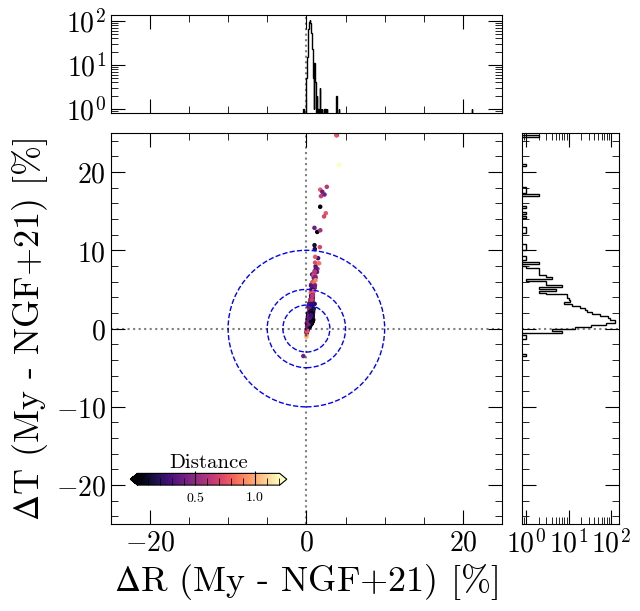

In [8]:
import matplotlib.patches as patches

def scatter_hist(x, y, z, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)
    # the scatter plot:
    scatter = ax.scatter(x, y, c = z, s = 5)
    ax.axhline(y = 0, ls = ':', alpha = 0.5, c = 'k')
    ax.axvline(x = 0, ls = ':', alpha = 0.5, c = 'k')
    # now determine nice limits by hand:
    binwidth = 0.5
    #xymax = max(np.max(np.abs(x)), np.max(np.abs(y)))
    #lim = (int(xymax/binwidth) + 1) * binwidth
    #bins = np.arange(-lim, lim + binwidth, binwidth)
    ax_histx.hist(x, color = 'k', histtype = 'step')
    ax_histx.axvline(x = 0, ls = ':', alpha = 0.5, c = 'k')
    ax_histy.hist(y, orientation='horizontal', color = 'k', histtype = 'step')
    ax_histy.axhline(y = 0, ls = ':', alpha = 0.5, c = 'k')
    ax_histx.set_yscale('log')
    ax_histy.set_xscale('log')
    return scatter

#fig, ax = plt.subplots(ncols=1, figsize=(8,6), sharey=False)
fig = plt.figure(layout='constrained', figsize=(8,6))
ax = fig.add_gridspec(top=0.75, right=0.75).subplots()
ax.set(aspect=1)

ax_histx = ax.inset_axes([0, 1.05, 1, 0.25], sharex=ax)
ax_histy = ax.inset_axes([1.05, 0, 0.25, 1], sharey=ax)

temp_compare = comparison.copy()
scatter_mass = scatter_hist(temp_compare.logg_pct_err, temp_compare.teff_pct_err, z = temp_compare.av, ax = ax, 
                            ax_histx = ax_histx, ax_histy = ax_histy)
confidence_ellipses = [3, 5, 10]
for val in confidence_ellipses:
    circle = patches.Circle((0, 0), val, edgecolor='blue', facecolor='none', ls = '--', linewidth=1, label='')
    ax.add_patch(circle)
ax.set_xlabel(r'$\Delta R$ (My - NGF+21) [%]')
ax.set_ylabel(r'$\Delta T$ (My - NGF+21) [%]')
ax.set_xlim(-25,25)
ax.set_ylim(-25,25)

#xvals = np.linspace(-20,20,100)
#ax.plot(xvals, 0.08*xvals**2-1)

cbaxes = ax.inset_axes([.05, .10, .4, .03]) 
cb = fig.colorbar(scatter_mass, cax=cbaxes, orientation='horizontal', extend="both")
cb.set_label(label=r"Distance", size=15,weight='bold')
cb.ax.tick_params(labelsize=10)
cbaxes.xaxis.set_label_position('top')

#fig.tight_layout()

/tmp/ipykernel_536887/2732820269.py:17: UserWarning: Adding colorbar to a different Figure <Figure size 700x700 with 1 Axes> than <Figure size 800x600 with 1 Axes> which fig.colorbar is called on.
  cb = fig.colorbar(CS, cax=cbaxes, orientation='horizontal', extend="both")


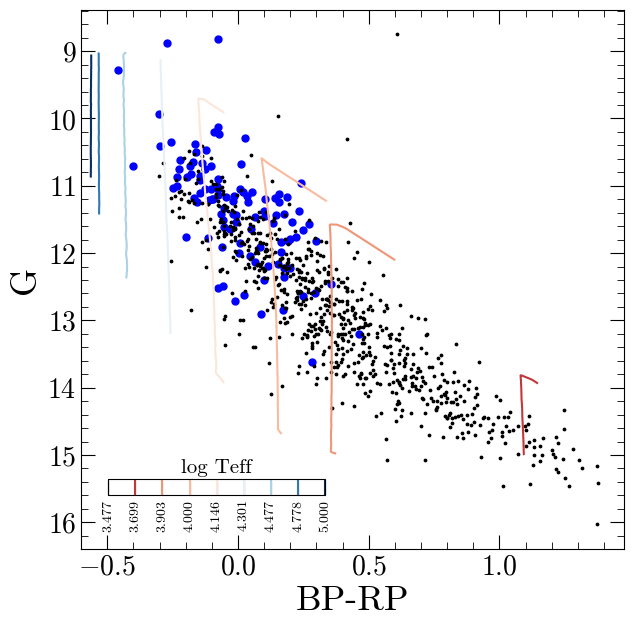

In [9]:
aaa = comparison.query("(teff_pct_err**2 + radius_pct_err**2) > 5**2 ")
bbb = comparison.query("(teff_pct_err**2 + radius_pct_err**2) < 5**2")

HR_grid = (-0.6, 1.25, 0.002, 9, 15, 0.01)
model  = WD_models.load_model(
    'be', 'be', 'be', 'H', 
    HR_bands=('bp3-rp3', 'G3'),
    HR_grid=HR_grid, 
    interp_type_atm='linear',
) 
CS = plt.contour(model['grid_HR_to_logteff'].T, #+ WD_models.MS_age(model['grid_HR_to_mass']).T*1e-9,
                 levels=np.log10([3000, 5000, 8000, 10000, 14000, 20000, 30000, 60000, 100000]), 
                 extent=(HR_grid[0],HR_grid[1],HR_grid[3],HR_grid[4]),
                 cmap='RdBu',)

cbaxes = plt.gca().inset_axes([.05, .10, .4, .03]) 
cb = fig.colorbar(CS, cax=cbaxes, orientation='horizontal', extend="both")
cb.set_label(label=r"log Teff", size=15,weight='bold')
cb.ax.tick_params(labelsize=10, rotation=90)
cbaxes.xaxis.set_label_position('top')

plt.scatter(aaa["BP-RP"], aaa.Gmag - 5*np.log10(aaa.rgeo)+5, c = 'blue', label=r"$\sqrt{(R\text{ %})^2 + (T\text{ %})^2} lt 7$")
plt.scatter(bbb["BP-RP"], bbb.Gmag - 5*np.log10(bbb.rgeo)+5, c='k', s=3, label=r"$\sqrt{(R\text{ %})^2 + (T\text{ %})^2} gt 7$")
plt.xlabel("BP-RP")
plt.ylabel("G")
#plt.legend()
plt.gca().invert_yaxis()

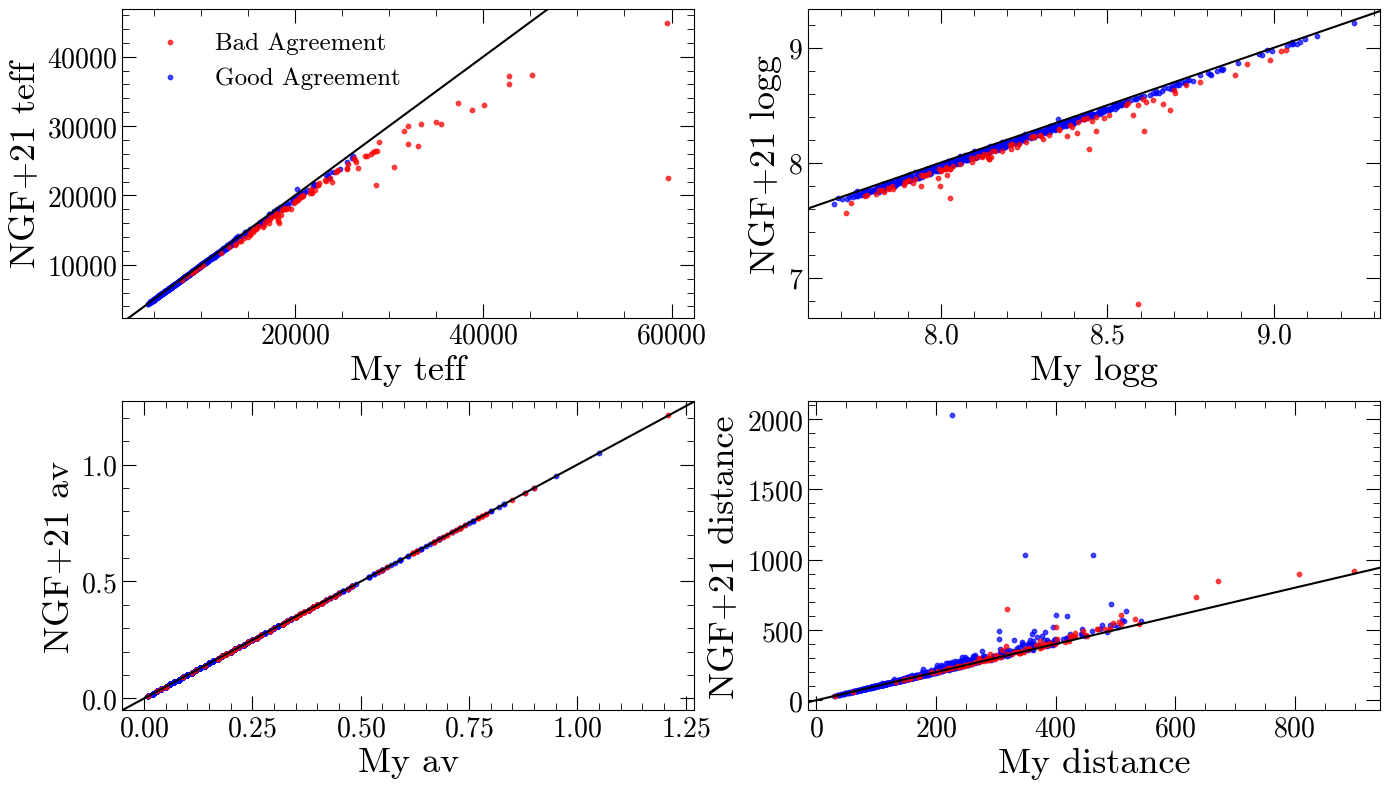

In [10]:
fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(14,8))
ax_flat = ax.flat

cols = [['teff', 'TeffH'], ['logg', 'loggH'], ['av', 'meanAV'], ['distance', 'rgeo']]
for i, axis in enumerate(ax_flat):
    axis.scatter(aaa[cols[i][0]], aaa[cols[i][1]], alpha=0.7, label='Bad Agreement', s=10, c='red')
    axis.scatter(bbb[cols[i][0]], bbb[cols[i][1]], alpha=0.7, label='Good Agreement', s=10, zorder=0, c='blue')
    xlims, ylims = axis.get_xlim(), axis.get_ylim()
    axis.plot(xlims, xlims, c='k')
    axis.set_xlim(xlims)
    axis.set_ylim(ylims)
    if i == 0:
        axis.legend(framealpha=0)
    axis.set_xlabel(f"My {cols[i][0]}")
    axis.set_ylabel(f"NGF+21 {cols[i][0]}")
fig.tight_layout()

/tmp/ipykernel_536887/3722933281.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(framealpha=0.1)


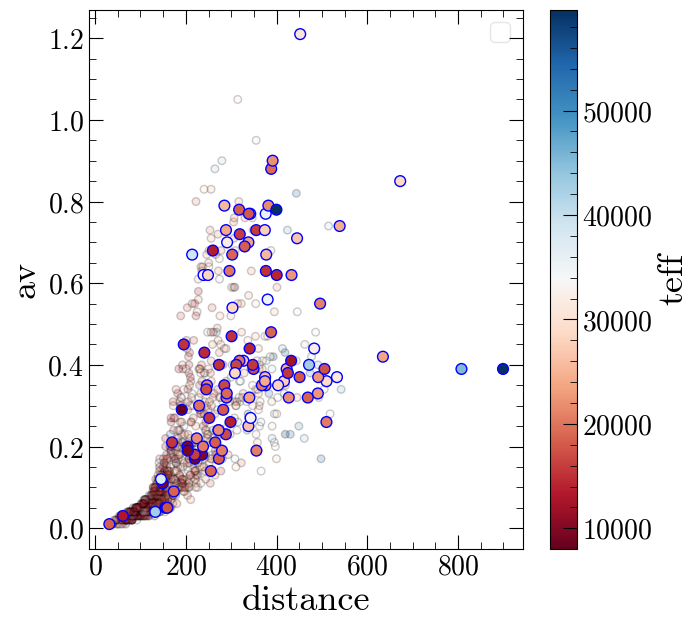

In [11]:
scatter1 = plt.scatter(aaa.distance, aaa.av, c = aaa.teff, s=60, linewidths=1, edgecolors='blue', cmap="RdBu")
scatter2 = plt.scatter(bbb.distance, bbb.av, c = bbb.teff, s=30, linewidths=1, edgecolors='k', cmap="RdBu", zorder=0, alpha=0.2)
plt.colorbar(scatter1, label="teff")
plt.xlabel(r'distance')
plt.ylabel(r'av')
plt.legend(framealpha=0.1)

## Test MCMC Engine

In [ ]:
import astropy.units as u
import lmfit
import pyphot

mass_sun, radius_sun, newton_G, speed_light = 1.9884e30, 6.957e8, 6.674e-11, 299792458
lib = pyphot.get_library()

def get_args_dict(row : pd.Series, res : lmfit.minimizer.MinimizerResult, interp : interpolator.WarwickPhotometry):
    factors = 0.0001*np.array([lib[band].lpivot.to('angstrom').value for band in interp.bands])*u.micron
    teff, e_teff, logg, e_logg = res.params['teff'].value, res.params['teff'].stderr, res.params['logg'].value, res.params['logg'].stderr
    plx, zp, e_plx, av, e_av = row.Plx, row.ZPcor, row.e_Plx, res.params['av'].value, 0.1*res.params['av'].value
    mags = row[['GmagCorr', 'BPmag', 'RPmag']].values
    e_mags = row[['e_GmagCorr', 'e_BPmag', 'e_RPmag']].values
    fluxes, e_fluxes = interpolator.fit.mag_to_flux(mags, e_mags, interp.bands)
    return {'flux' : fluxes, 'e_flux' : e_fluxes, 'factors' : factors, 'teff_obs' : teff, 'e_teff_obs' : e_teff,
            'logg' : logg, 'e_logg' : e_logg, 'plx' : plx+zp, 'e_plx' : e_plx, 'av' : av, 'e_av' : e_av, 'interpolator' : interp}

def log_prob(theta, args_dict, likelihood, logg_function = None, vg = None, e_vg = None):
    if logg_function == None:
        teff, radius, distance, av, mass = theta
        vg_th = (newton_G * mass * mass_sun) / (speed_light * radius * radius_sun) * 1e-3
        logg = np.log10(100*(newton_G * mass_sun * mass) / (radius * radius_sun)**2)
        bounds = np.array([[1000, 100000], [0.002, 0.05], [10, 2000], [1e-4, 1], [0.1, 1.4]])
    else:
        teff, logg, distance, av = theta
        radius = logg_function(teff, logg)
        mass = (1e-2*np.power(10, logg)) * (radius * radius_sun)**2 / (newton_G * mass_sun)
        vg_th = (newton_G * mass * mass_sun) / (speed_light * radius * radius_sun) * 1e-3
        bounds = np.array([[1000, 100000], [7, 9.4], [10, 2000], [1e-4, 1]])
    # compute likelihoods
    ll  = likelihood.ll(theta, logg_function = logg_function)
    distance_lp = likelihood.gaussian_prior(1000/distance, args_dict['plx'], args_dict['e_plx']) + 2*np.log(distance)
    av_lp = likelihood.gaussian_prior(av, args_dict['av'], args_dict['e_av'])
    teff_lp = likelihood.gaussian_prior(teff, args_dict['teff_obs'], args_dict['e_teff_obs'])
    logg_lp = likelihood.gaussian_prior(logg, args_dict['logg'], args_dict['e_logg'])
    gravz_lp = likelihood.gaussian_prior(vg_th, vg, e_vg) if (vg is not None) and (e_vg is not None) else 0
    uniform = likelihood.uniform_prior(theta, bounds)
    log_likelihood = ll + distance_lp + av_lp + teff_lp + logg_lp + uniform + gravz_lp
    return log_likelihood if ~np.isnan(log_likelihood) else -np.inf

for i, row in tqdm.tqdm(ngfdata.iterrows(), total=len(ngfdata)):
    res = fit_row(row, interp)
    args_dict = get_args_dict(row, res, interp)
    likelihood = interpolator.fit.Likelihood(flux = args_dict['flux'], e_flux = args_dict['e_flux'], 
                                             interp = args_dict['interpolator'])
    theta_mrr = np.array([args_dict['teff_obs'], 8, 100, args_dict['av']])
    loss_args_mrr = {'args_dict' : args_dict, 'likelihood' : likelihood, 'logg_function' : logg_function}
    chain_mrr = interpolator.fit.mcmc_fit(log_prob, loss_args=loss_args_mrr, initial_guess = theta_mrr)   
    theta = np.array([args_dict['teff_obs'], 0.012, 100, args_dict['av'], 0.6])
    loss_args = {'args_dict' : args_dict, 'likelihood' : likelihood, 'logg_function' : None}
    chain = interpolator.fit.mcmc_fit(log_prob, loss_args=loss_args, initial_guess = theta)   
    break

100%|██████████| 1000/1000 [00:05<00:00, 183.61it/s]
The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [77.68320702 90.08121534 53.48075343 59.73588264]
100%|██████████| 1000/1000 [00:03<00:00, 299.69it/s]
The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [87.68187597 97.4531979  60.59600302 49.10015885 55.01777396]
  0%|          | 0/1000 [00:41<?, ?it/s]


{'flux': array([7.24914091e-17, 8.54585318e-17, 5.09326937e-17]),
 'e_flux': array([2.946493062973565e-19, 4.3826049231776635e-18,
        3.546125135003202e-18], dtype=object),
 'factors': <Quantity [0.62562059, 0.51338488, 0.78359797] micron>,
 'teff_obs': np.float64(6038.325124809544),
 'e_teff_obs': np.float64(442.84999424383903),
 'logg': np.float64(8.482496964323676),
 'e_logg': np.float64(0.19033004998246256),
 'plx': 14.845374999999999,
 'e_plx': 0.2161,
 'av': 0.01,
 'e_av': 0.001,
 'interpolator': <interpolator.interpolator.WarwickPhotometry at 0x7fcf97d1aa50>}

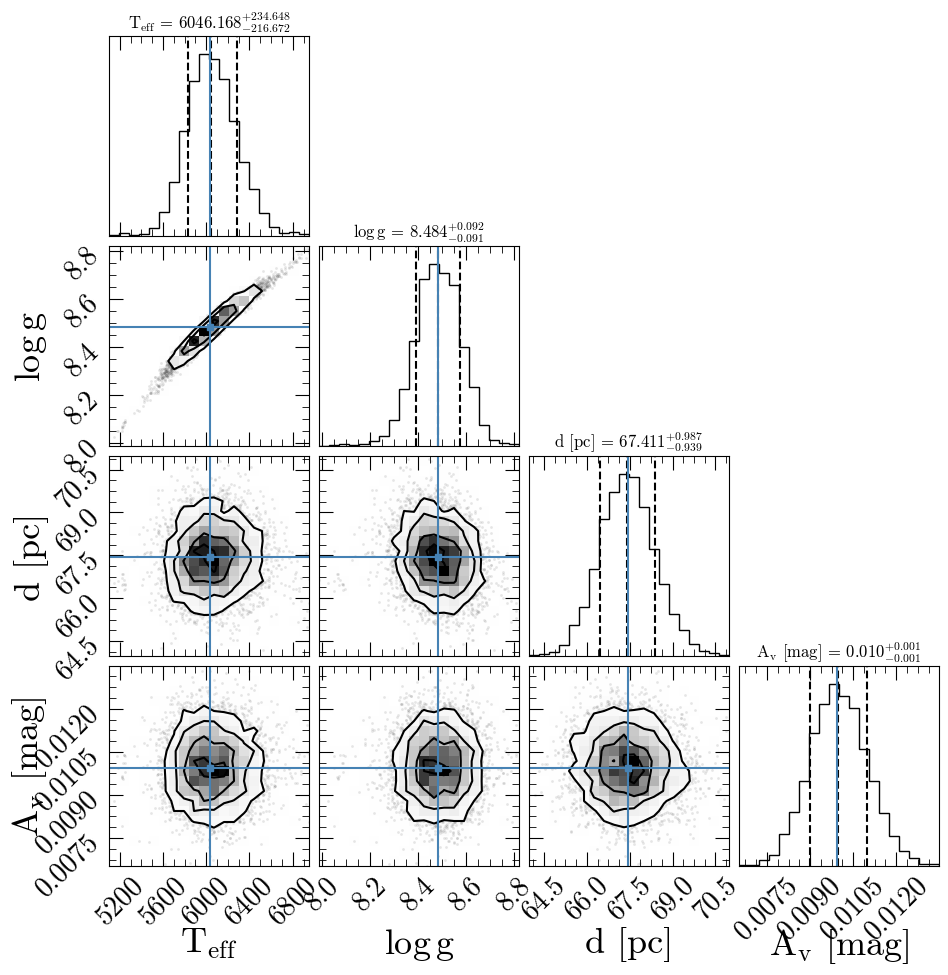

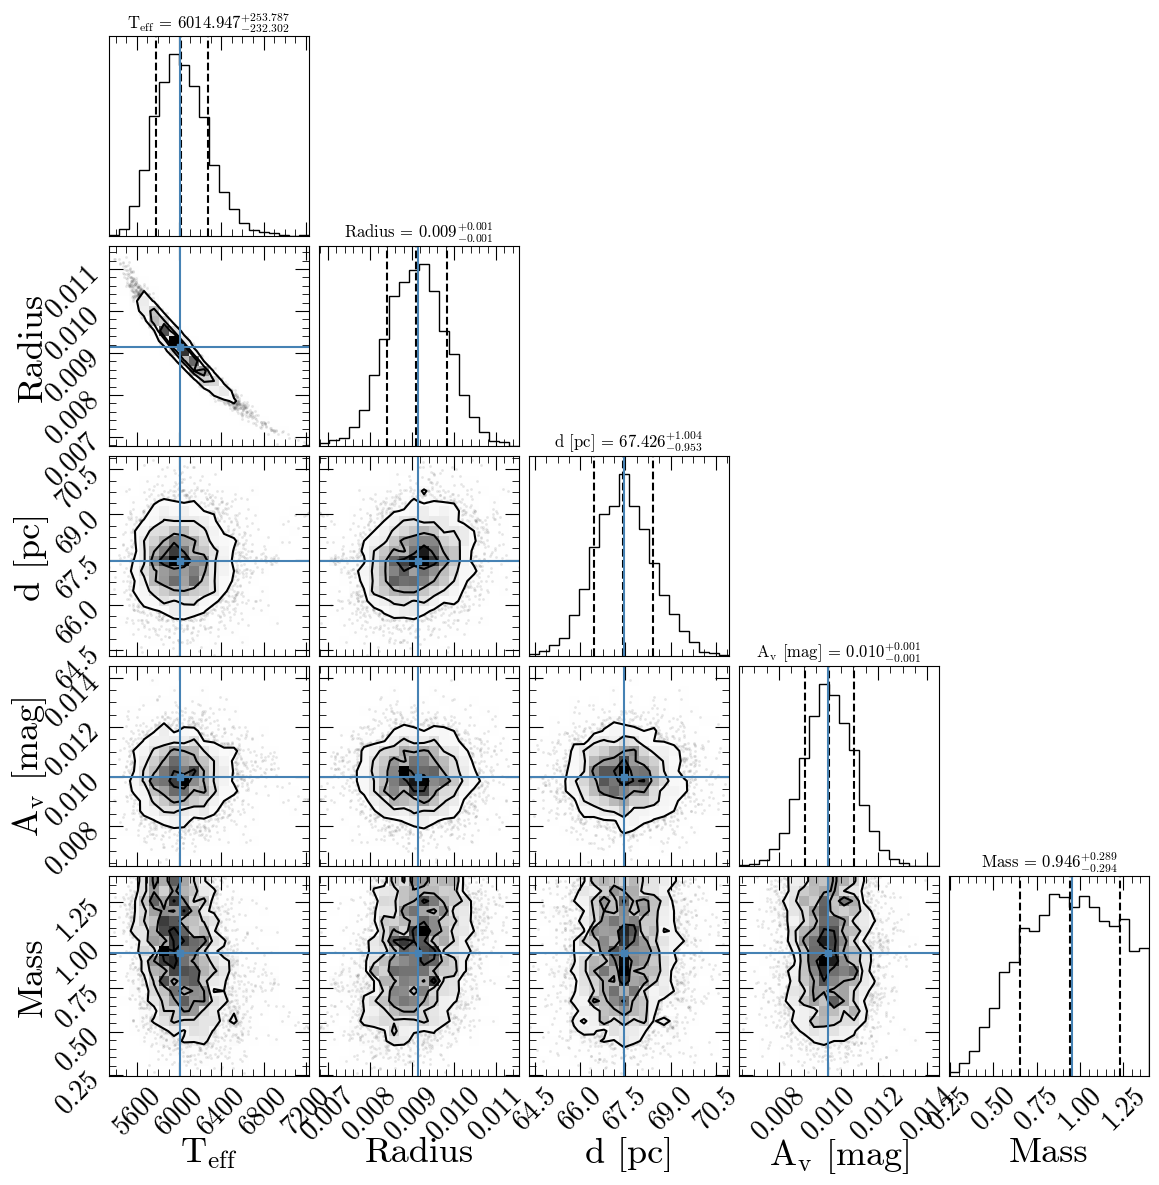

In [23]:
corner_mrr = interpolator.fit.plot_chain(chain_mrr, labels = [r'$T_\text{eff}$', r'$\log g$', r'd [pc]', r'$A_v$ [mag]'],)
corner = interpolator.fit.plot_chain(chain, labels = [r'$T_\text{eff}$', r'Radius', r'd [pc]', r'$A_v$ [mag]', 'Mass'])